In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
from scipy import stats     
from tensorflow.keras.preprocessing.sequence import pad_sequences

def create_sequences_and_labels(sequences, max_len):
    """
    Cria sub-sequências de treinamento e seus rótulos.
    Ex: para [1,2,3,4], cria ([1],2), ([1,2],3), ([1,2,3],4)
    """
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            X.append(seq[:i][-max_len:])
            y.append(seq[i])
    return X, y


df = pd.read_excel(
    "Pedidos.xlsx",
    parse_dates=["DataFechamento"]  # Converte diretamente essa coluna para datetime
)

# Ver linhas com valores negativos
linhas_removidas = (df["qtde_vendida"] < 0).sum()
print("Linhas a remover:", linhas_removidas)

df = df[df["qtde_vendida"] >= 0].copy()  

df = df[df["DataFechamento"].dt.year < 2025].copy()
df = df.drop_duplicates()

# Z-score da coluna 'valor_pedido'
z_scores = stats.zscore(df['valor_pedido'])
df_sem_outliers = df[(z_scores > -3) & (z_scores < 3)]

max_len = 10 # Define o comprimento máximo das sequências 

# Split temporal
train_max_date = pd.to_datetime('2022-12-31') 
val_max_date = pd.to_datetime('2023-12-31') 

unique_products = df_sem_outliers['codigo_produto'].unique() # -- Obtem uma lista de produtos únicos
product_to_int = {product: i + 1 for i, product in enumerate(unique_products)} # Cria um dicionário que transforma cada código de produto em um número inteiro. i + 1 garante que o índice comece em 1 (não usamos 0 porque geralmente reservamos 0 para padding).
df_sem_outliers['product_id'] = df_sem_outliers['codigo_produto'].map(product_to_int) # Cria uma nova coluna product_id que substitui o código original do produto pelo número inteiro correspondente.


test_sequences = df_sem_outliers[df_sem_outliers['DataFechamento'] > val_max_date] \
    .groupby('numero_pedido')['product_id'].apply(list).tolist() # Depois disso vai para teste.
 
test_sequences = [s for s in test_sequences if len(s) > 1]

X_test, y_test = create_sequences_and_labels(test_sequences, max_len)

X_test  = pad_sequences(X_test,  maxlen=max_len, padding='post')
y_test  = np.array(y_test)

Linhas a remover: 14


/tmp/ipykernel_7593/3152474739.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_outliers['product_id'] = df_sem_outliers['codigo_produto'].map(product_to_int) # Cria uma nova coluna product_id que substitui o código original do produto pelo número inteiro correspondente.


/home/brunobersan/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

📊 Relatório de classificação:
              precision    recall  f1-score   support

         709       0.44      0.58      0.50       156
         710       0.00      0.00      0.00        79
         712       0.05      0.02      0.03       712
         713       0.00      0.00      0.00       160
         714       0.00      0.00      0.00       445
         715       0.07      0.11      0.09       701
         716       0.00      0.00      0.00        65
         717       0.00      0.00      0.00       243
         718       0.00      0.00      0.00       323
         719       0.00      0.00      0.00        18
         721       0.31      0.43      0.36        60
         723       0.15      0.10      0.12       118
         724       0.00      0.00      0.00       112
         725       0.07      0.20      0.10       936
         726       0.00      0.00      0.00       356
         727       0.00      0.00      0.00         6
         

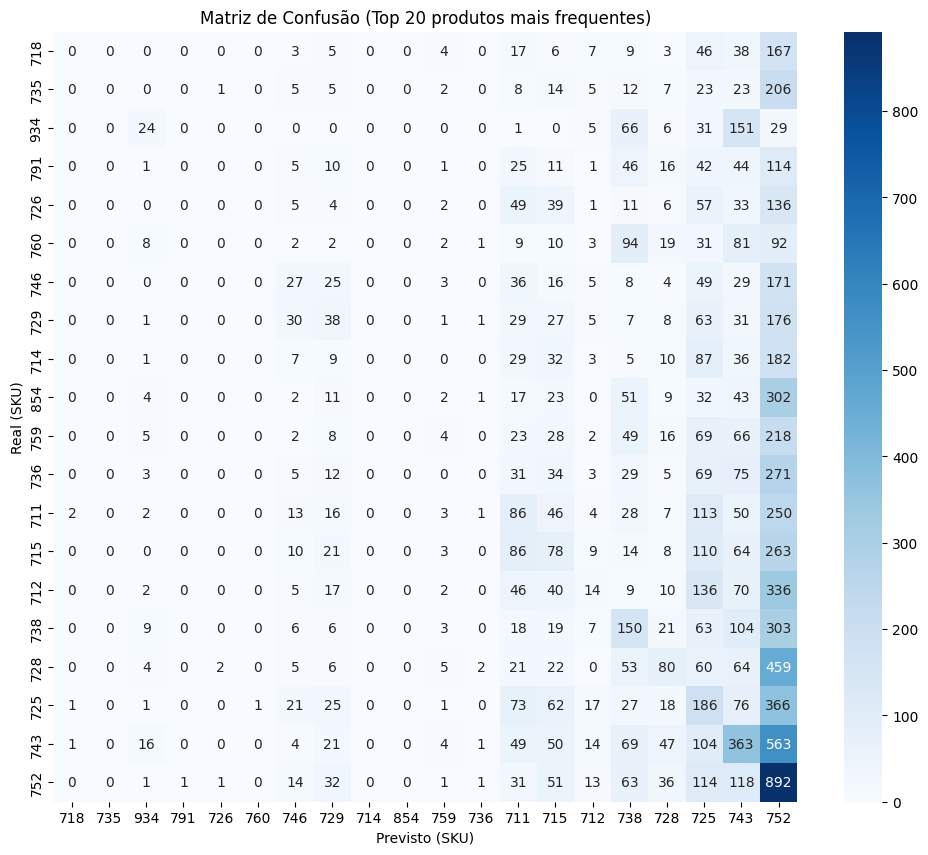

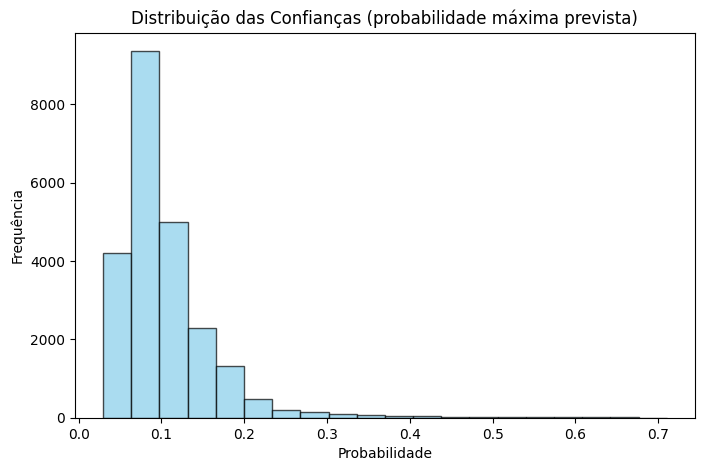


📈 Análise de Desequilíbrio de Classes:


/tmp/ipykernel_7593/3076191341.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SKU', y='Contagem', data=df_counts, palette="viridis")


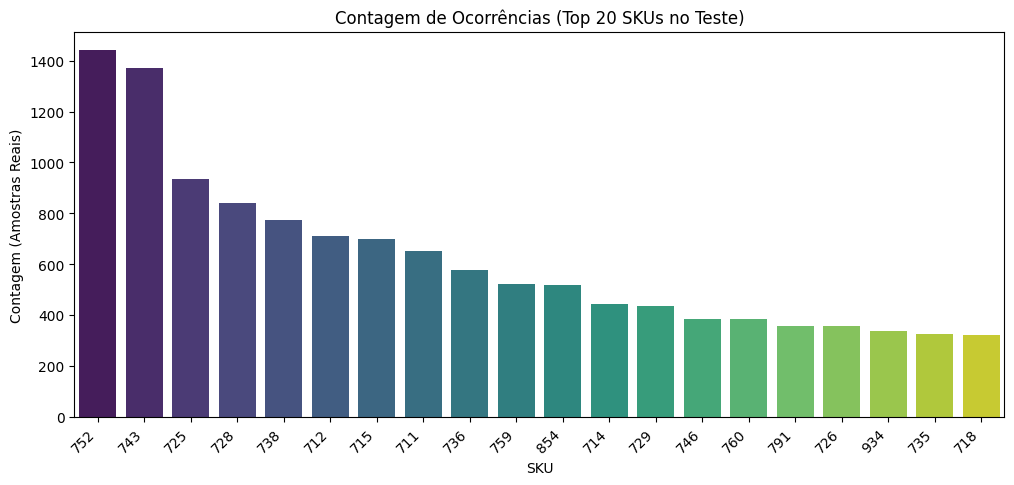


⭐ Análise Detalhada de Métricas por SKU:


/tmp/ipykernel_7593/3076191341.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SKU', y='f1-score', data=df_metrics.sort_values(by='f1-score', ascending=False), palette="coolwarm")


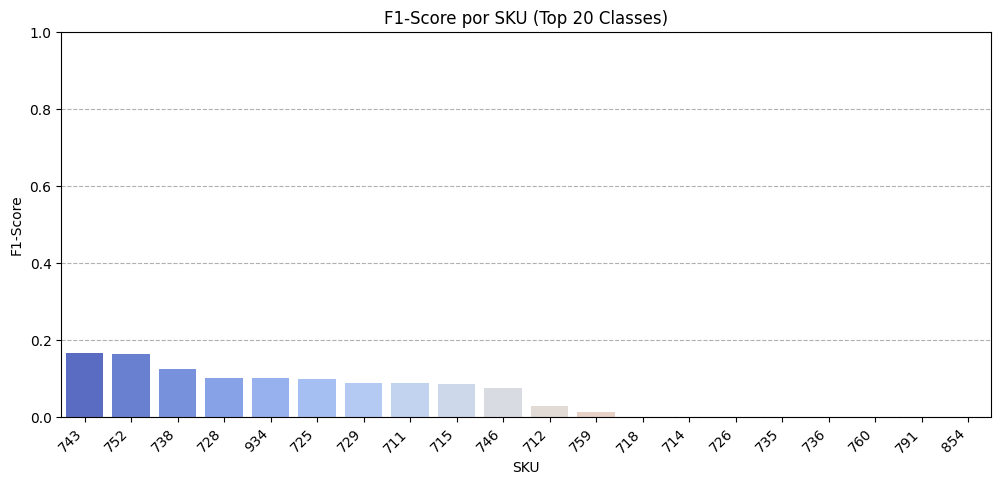

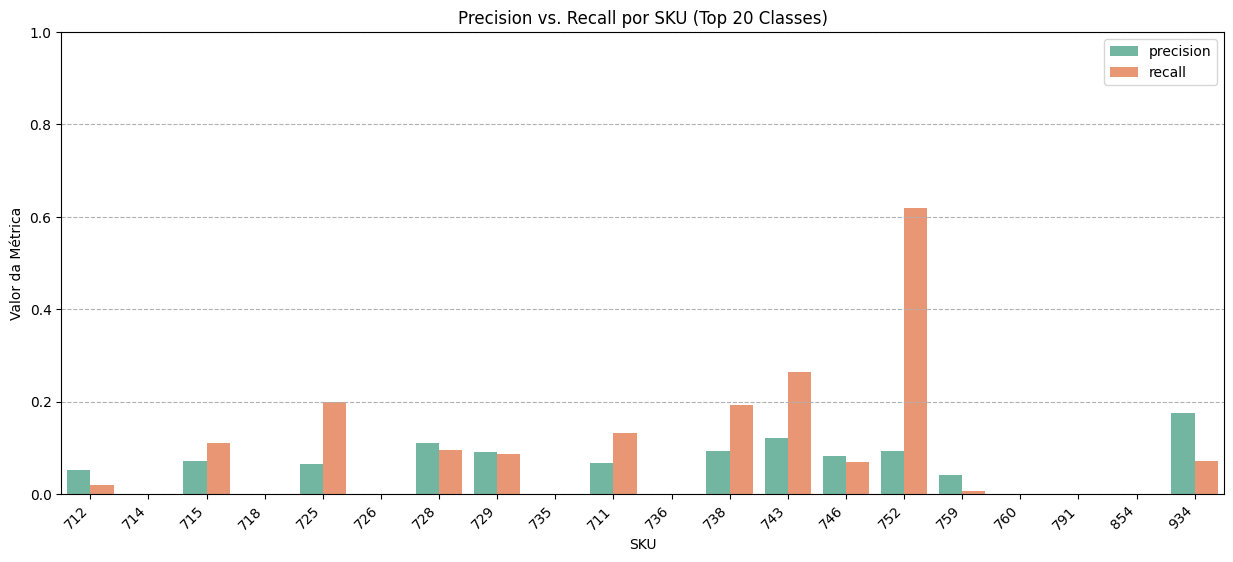

In [16]:
# 🔹 Carregar modelo salvo
modelo = load_model("modelo_total_dados_ULTIMO2.keras")

# 🔹 Fazer previsões
y_proba = modelo.predict(X_test)            
y_pred = np.argmax(y_proba, axis=1)         
y_true = y_test if len(y_test.shape) == 1 else np.argmax(y_test, axis=1)  
int_to_product = {v: k for k, v in product_to_int.items()} 
 

# 🔹 Função de avaliação adaptada com SKUs (COM NOVOS GRÁFICOS)
def avaliar_classificacao(y_true, y_pred, y_proba, int_to_product, k_list=[1,3,5], top_n_cm=20):
    """
    Avalia o desempenho do modelo:
    - Relatório de classificação (inclui Precision, Recall, F1-Score)
    - Top-K accuracy
    - Matriz de confusão (apenas top_n_cm classes mais frequentes, mostrando SKUs reais)
    - Distribuição das confianças
    
    NOVOS GRÁFICOS:
    - Contagem de Classes (Desequilíbrio de Classes)
    - Gráfico de Barras de Métricas por Classe (F1-Score, etc.)
    """

    labels, counts = np.unique(y_true, return_counts=True)

    # Converte para SKUs reais
    target_names = [str(int_to_product[l]) for l in labels]
    
    # -------------------------------------------------------------
    # 1. Relatório de Classificação e Top-K Accuracy
    # -------------------------------------------------------------

    print("\n📊 Relatório de classificação:")
    report_dict = classification_report(
        y_true, 
        y_pred, 
        labels=labels, 
        target_names=target_names, 
        zero_division=0,
        output_dict=True # Saída como dicionário para uso posterior
    )
    print(classification_report(
        y_true, 
        y_pred, 
        labels=labels, 
        target_names=target_names, 
        zero_division=0
    ))

    # Top-K Accuracies
    for k in k_list:
        topk_acc = top_k_accuracy_score(
            y_true, y_proba, k=k, labels=np.arange(y_proba.shape[1])
        )
        print(f"Top-{k} Accuracy: {topk_acc:.4f}")
        
    # -------------------------------------------------------------
    # 2. Matriz de Confusão (Top N)
    # -------------------------------------------------------------

    top_classes = labels[np.argsort(counts)[-top_n_cm:]]
    top_target_names = [str(int_to_product[l]) for l in top_classes]
    cm = confusion_matrix(y_true, y_pred, labels=top_classes)
    
    plt.figure(figsize=(12,10))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", 
        xticklabels=top_target_names, 
        yticklabels=top_target_names
    )
    plt.xlabel("Previsto (SKU)")
    plt.ylabel("Real (SKU)")
    plt.title(f"Matriz de Confusão (Top {top_n_cm} produtos mais frequentes)")
    plt.show()

    # -------------------------------------------------------------
    # 3. Distribuição das Confianças
    # -------------------------------------------------------------

    plt.figure(figsize=(8,5))
    plt.hist(np.max(y_proba, axis=1), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title("Distribuição das Confianças (probabilidade máxima prevista)")
    plt.xlabel("Probabilidade")
    plt.ylabel("Frequência")
    plt.show()
    
    # -------------------------------------------------------------
    # 🌟 NOVO GRÁFICO 1: Contagem de Classes (Desequilíbrio)
    # -------------------------------------------------------------
    print("\n📈 Análise de Desequilíbrio de Classes:")
    df_counts = pd.DataFrame({'SKU': target_names, 'Contagem': counts})
    df_counts = df_counts.sort_values(by='Contagem', ascending=False).head(top_n_cm)

    plt.figure(figsize=(12, 5))
    sns.barplot(x='SKU', y='Contagem', data=df_counts, palette="viridis")
    plt.title(f"Contagem de Ocorrências (Top {top_n_cm} SKUs no Teste)")
    plt.xlabel("SKU")
    plt.ylabel("Contagem (Amostras Reais)")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # -------------------------------------------------------------
    # 🌟 NOVO GRÁFICO 2: Métricas por Classe (F1-Score, Precision, Recall)
    # -------------------------------------------------------------
    print("\n⭐ Análise Detalhada de Métricas por SKU:")
    
    # Constrói o DataFrame de métricas
    df_metrics = pd.DataFrame(report_dict).transpose()
    df_metrics = df_metrics.iloc[:-3] # Remove support, accuracy, macro avg, weighted avg
    df_metrics = df_metrics.reset_index().rename(columns={'index': 'SKU'})
    
    # Filtra apenas os SKUs plotados na CM (para consistência visual)
    df_metrics = df_metrics[df_metrics['SKU'].isin(top_target_names)]
    
    # Plota o F1-Score (o mais revelador)
    plt.figure(figsize=(12, 5))
    sns.barplot(x='SKU', y='f1-score', data=df_metrics.sort_values(by='f1-score', ascending=False), palette="coolwarm")
    plt.title(f"F1-Score por SKU (Top {top_n_cm} Classes)")
    plt.xlabel("SKU")
    plt.ylabel("F1-Score")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--')
    plt.show()
    
    # Opcional: Plota Precision e Recall juntos
    df_metrics_melted = df_metrics.melt(id_vars='SKU', value_vars=['precision', 'recall'], var_name='Métrica', value_name='Valor')
    df_metrics_melted = df_metrics_melted[df_metrics_melted['SKU'].isin(top_target_names)]
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x='SKU', y='Valor', hue='Métrica', data=df_metrics_melted, palette="Set2")
    plt.title(f"Precision vs. Recall por SKU (Top {top_n_cm} Classes)")
    plt.xlabel("SKU")
    plt.ylabel("Valor da Métrica")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--')
    plt.show()


# 🔹 Chamada de avaliação (mantida, use após definir a função)
# avaliar_classificacao(y_true, y_pred, y_proba, int_to_product)

# 🔹 Chamada de avaliação
avaliar_classificacao(y_true, y_pred, y_proba, int_to_product)
